<a href="https://colab.research.google.com/github/Seongjin1225/AI_SCHOOL_9/blob/main/ML%26DL/12%EC%9B%94%2019%EC%9D%BC/12%EC%9B%94_19%EC%9D%BC_%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 전이학습(Transfer Learning)을 구현해 보아요!
# 사용하는 Pretrained Network(Model)은 VGG16을 사용
# 데이터는 개, 고양이 이진분류 예제
# 이미지의 pixel 데이터 추출 시, ImageDataGenerator 사용 & Augumentation(증식)까지 포함

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16

In [ ]:
# Raw Data Loading => 원래는 이거였음
# ImageDataGenerator 이용해서 데이터 전처리

train_dir = '/content/drive/MyDrive/AI스쿨 파일/ML/cat_dog_small/train'
validation_dir = '/content/drive/MyDrive/AI스쿨 파일/ML/cat_dog_small/validation'

# ImageDataGenerator 생성 - 정규화, 증식 처리
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=30,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                  fill_mode='nearest')

# validation은 평가용이기 때문에 증식 해당 ㄴㄴ
validation_datagen = ImageDataGenerator(rescale=1/255)

# 각 ImageDataGenerator 어떻게 동작하는 지 설정
train_generator = train_datagen.flow_from_directory(
    train_dir,
    classes=['cats', 'dogs'],  # label 처리
    target_size=(224,224),
    batch_size=20,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    classes=['cats', 'dogs'],  # label 처리
    target_size=(224,224),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
# model 생성
# CNN 모델 중 Feature Extraction 부분은 VGG16을 이용해 사용(전이 학습)
# classifier 부분만 직접 구현

# Pretrained Network
model_base = VGG16(weights='imagenet',
                   include_top=False,  # False -> classifier 포함 X, 데이터가 올라가는 개념이라 뒤쪽이 위쪽!
                   input_shape=(224,224,3)) # 이미 설정되어 있는 사이즈 굳이 변경할 필요는 없으므로 224 그대로 진행
model_base.trainable = False  # Convolution Layer 동결(trainable params가 0이 되도록)
                              # 반드시 해줘야 한다!!!

# 이미지 1장이 결국 [7, 7, 512] 형태로 변환
# 기본적으로 classifier가 포함 -> 사용할 수 없으니 제거!

# Total params: 14714688 (56.13 MB) => 전체 파라미터의 수
# Trainable params: 14714688 (56.13 MB) => 학습할때 갱신되는 파라미터 수
# => epoch이 진행될 때 자동으로 update되는 파라미터 수
# => 학습이 안되도록 처리해야 한다!
# Non-trainable params: 0 (0.00 Byte)

# classifier 구현
model = Sequential()
model.add(model_base)  # 우리 모델 앞부분에 pretrained network 삽입

model.add(Flatten())

# hidden layer
model.add(Dense(units=512,
                activation='relu'))

# Dropout - 앞뒤 어디든 상관 없음 위치는
model.add(Dropout(rate=0.5))  # 반을 잘라낸다는 의미
                              # overfitting 피하기 위해서(연산 참여 노드 개수 반으로)

# output layer
model.add(Dense(units=1,
                activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=30,
                    validation_data = validation_generator,
                    validation_steps=50,
                    verbose=1)

Epoch 1/30
100/100 [==============================] - 480s 5s/step - loss: 0.5239 - acc: 0.7505 - val_loss: 0.2630 - val_acc: 0.8930
Epoch 2/30
100/100 [==============================] - 37s 365ms/step - loss: 0.3572 - acc: 0.8365 - val_loss: 0.2875 - val_acc: 0.8760
Epoch 3/30
100/100 [==============================] - 37s 372ms/step - loss: 0.3165 - acc: 0.8690 - val_loss: 0.2169 - val_acc: 0.9190
Epoch 4/30
100/100 [==============================] - 37s 365ms/step - loss: 0.2756 - acc: 0.8845 - val_loss: 0.2287 - val_acc: 0.9110
Epoch 5/30
100/100 [==============================] - 37s 367ms/step - loss: 0.2624 - acc: 0.8885 - val_loss: 0.1945 - val_acc: 0.9190
Epoch 6/30
100/100 [==============================] - 37s 367ms/step - loss: 0.2546 - acc: 0.8950 - val_loss: 0.1974 - val_acc: 0.9180
Epoch 7/30
100/100 [==============================] - 36s 365ms/step - loss: 0.2400 - acc: 0.9045 - val_loss: 0.1932 - val_acc: 0.9200
Epoch 8/30
100/100 [==============================] - 37s

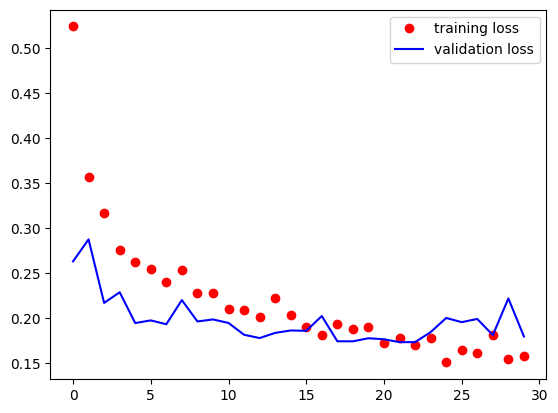

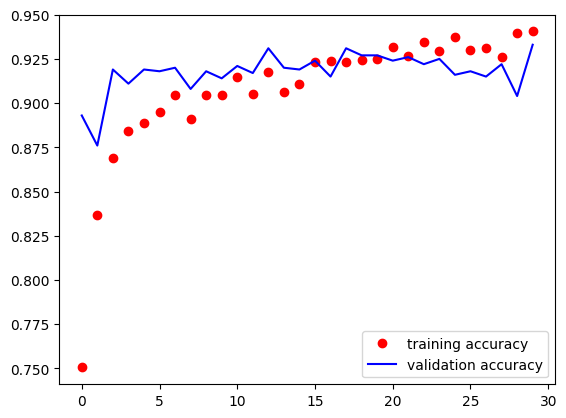

In [ ]:
# 학습이 끝난 다음에 시각화해서 overfitting 발생하는지 확인
# loss와 val_loss, acc와 val_acc를 비교해서 overfitting의 정도 확인
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

train_acc = history.history['acc']
valid_acc = history.history['val_acc']

plt.plot(train_loss,
         'o',
         color='r',
         label='training loss')

plt.plot(valid_loss,
         color='b',
         label='validation loss')
plt.legend()
plt.show()

plt.plot(train_acc,
         'o',
         color='r',
         label='training accuracy')

plt.plot(valid_acc,
         color='b',
         label='validation accuracy')
plt.legend()
plt.show()

In [ ]:
# 학습한 모델 일단 파일로 저장
model.save('/content/drive/MyDrive/AI스쿨 파일/ML/cat_dog_small/12.19.CNN_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Fine Tuning
# 이미 위쪽에서 학습이 한번 끝났기 때문에 추가적으로
# 상위 convolution layer의 동결을 풀고 학습 한번 더 수행!

# 파일로 저장되어 있는 model loading
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/AI스쿨 파일/ML/cat_dog_small/12.19.CNN_model.h5')
# model.summary()

# 여기까지가 한번 Transfer Leraning을 이용해서 학습이 완료된 상태
# 일부 layer에 대한 동결을 해제 후 진행
model_base = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(224,224,3))

model_base.trainable = False

for layer in model_base.layers:
    if layer.name in ['block5_conv1','block5_conv2','block5_conv3']:
        layer.trainable=True
    else:
        layer.trainale=False

# 이렇게 모델을 다시 만들고 학습을 한번 더 진행
# fine tuning!(큰 변화는 아니지만 어느정도 모델의 정확도를 올릴 수 있다)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 512)               12845568  
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 513       
                                                                 
Total params: 27560769 (105.14 MB)
Trainable params: 12846081 (49.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


# NLP 부분

In [ ]:
# IMDB Review Data Set load
# tensorflow keras에는 이미 정수로 바꾼 Review 데이터가 포함!
# 가장 많이 등장하는 단어 500개만 vocabulary로 사용해서 데이터 적재
from tensorflow.keras.datasets import imdb
(x_data_train, t_data_train), (x_data_test,t_data_test) = \
imdb.load_data(num_words=500)

17464789/17464789 [==============================] - 1s 0us/step


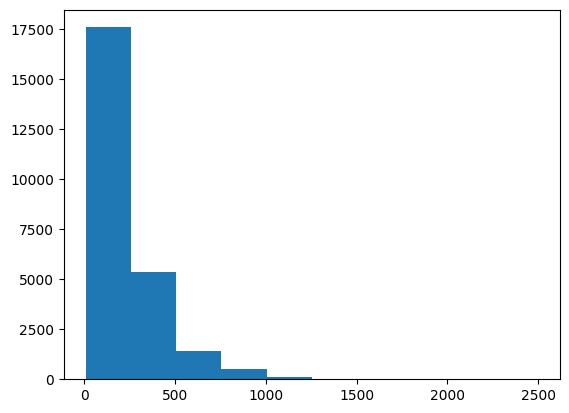

(25000, 100)

In [ ]:
# 적재 완료 후 데이터가 어떻게 구성되는지 한번 알아보자
x_data_train.shape  # (25000,)
t_data_train.shape  # (25000,)
x_data_test.shape  # (25000,)
t_data_test.shape  # (25000,)

# train data : 25000개, test data : 25000개
# t_data_train 내용 살짝 보면
t_data_train[:10]  # [1, 0, 0, 1, 0, 0, 1, 0, 1, 0] 0은 부정 1은 긍정
type(x_data_train)
type(x_data_train[0])

# 첫번째 review의 길이
len(x_data_train[0])
# 두번째 review의 길이
len(x_data_train[1])

# padding에 대해 알아보아요
# 각 review의 길이에 대해 알아보기
import numpy as np
import matplotlib.pyplot as plt
lengths = np.array([len(x) for x in x_data_train])
lengths[:10]

np.mean(lengths)
np.median(lengths)

plt.hist(lengths)
plt.show()

# 평균, 중위값, 히스토그램을 살펴본 결과
# 대부분의 review는 길이가 300 token 미만인걸로 파악
# 실제로는 100 token 미만인 경우가 대다수일 것!

# 모든 review의 길이를 100으로 통일
# 100보다 긴 것은 짤리고
# 짧은것은 채워줘야! => 이때 사용하는게 padding
# 짜르는 경우 -> 앞쪽을 자른
# 채워주는 경우 -> padding을 앞쪽에 붙여야 한다

# 이 작업하기 위해 keras가 함수를 제공해 준다!
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_data_train_seq = pad_sequences(x_data_train, maxlen=100)
type(x_data_train_seq)
x_data_train_seq.shape  # (25000,100)
# 25,000개의 review, 각 review는 100개의 token으로 재단되었